In [106]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torchvision import datasets, io
from torch.utils.data import DataLoader,Dataset
from torchvision import datasets, transforms,models
from torchvision.transforms import InterpolationMode
from torchinfo import summary
import sys
import os

In [74]:
!pip install torchinfo

In [63]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!mkdir -p ~/.config/kaggle
!cp /content/drive/MyDrive/kaggle.json ~/.config/kaggle/
!chmod 600 ~/.config/kaggle/kaggle.json

In [7]:
sys.path.append('/content/drive/MyDrive/expression_recognition')

**Project**:<br>
*the main goal of this project is to recognise simple math operations on one digit numbers.
ex: 2 + 2 and 3 - 1 and 5 * 5 and 10 / 100 and etc.
the idea is to recognise the numbers, operations and output the result.
at this stage and just for demonstration this project only focuses on on digit operations. italicised text*


**Getting the data**<br>
injesting the data, analysing and displaying them

In [9]:
dataset = datasets.MNIST

In [10]:
# Setup training data
train_data = datasets.MNIST(
    root="data", # where to download data to?
    train=True, # get training data
    download=True, # download data if it doesn't exist on disk
    transform=transforms.ToTensor(), # images come as PIL format, we want to turn into Torch tensors
    target_transform=None # you can transform labels as well
)

# Setup testing data
test_data = datasets.MNIST(
    root="data",
    train=False, # get test data
    download=True,
    transform=transforms.ToTensor()
)

In [ ]:
# See first training sample
image, label = train_data[0]
image, label

In [12]:
# What's the shape of the image?
image.shape

torch.Size([1, 28, 28])

In [13]:
# How many samples are there?
len(train_data.data), len(train_data.targets), len(test_data.data), len(test_data.targets)

(60000, 60000, 10000, 10000)

In [14]:
# See classes
class_names = train_data.classes
class_names

['0 - zero',
 '1 - one',
 '2 - two',
 '3 - three',
 '4 - four',
 '5 - five',
 '6 - six',
 '7 - seven',
 '8 - eight',
 '9 - nine']

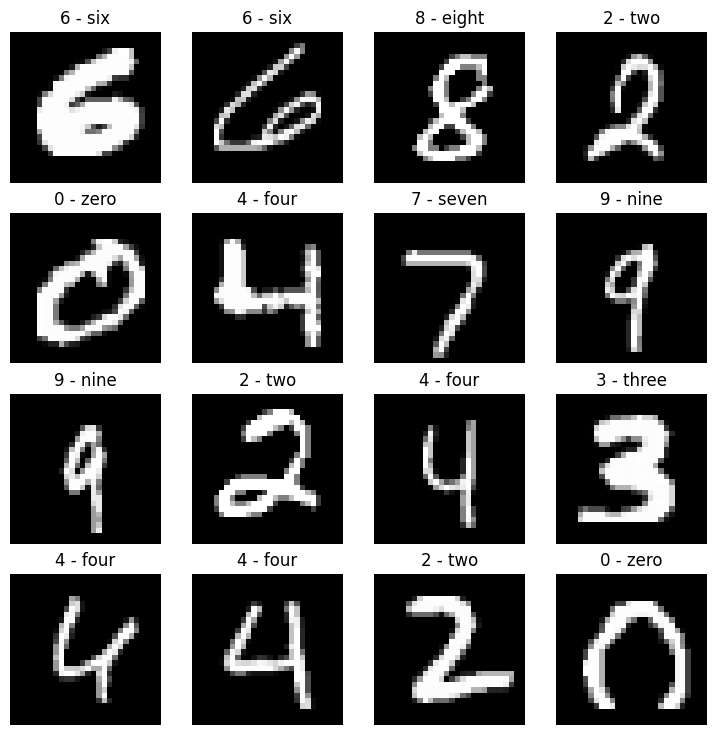

In [15]:
# Plot more images
torch.manual_seed(42)
fig = plt.figure(figsize=(9, 9))
rows, cols = 4, 4
for i in range(1, rows * cols + 1):
    random_idx = torch.randint(0, len(train_data), size=[1]).item()
    img, label = train_data[random_idx]
    fig.add_subplot(rows, cols, i)
    plt.imshow(img.squeeze(), cmap="gray")
    plt.title(class_names[label])
    plt.axis(False);

To get the data for the basic operations we can use kaggle

In [ ]:
# from kaggle.api.kaggle_api_extended import KaggleApi
# # --- STEP 1: Set up Kaggle credentials ---
# # Path to kaggle.json in your Google Drive
# kaggle_json_path = '/content/drive/MyDrive/kaggle.json'

# os.makedirs(os.path.expanduser('~/.config/kaggle'), exist_ok=True)

# # Copy kaggle.json to expected location
# !cp "{kaggle_json_path}" ~/.config/kaggle/
# os.chmod(os.path.expanduser('~/.config/kaggle/kaggle.json'), 0o600)

# # --- STEP 2: Initialize Kaggle API ---
# api = KaggleApi()
# api.authenticate()

# # --- STEP 3: Download a dataset ---
# # Example: Titanic dataset
# dataset_name = 'clarencezhao/handwritten-math-symbol-dataset'
# download_path = './handwritten_operations'  # folder where the dataset will be saved

# api.dataset_download_files(dataset_name, path=download_path, unzip=True)

# print(f"Dataset downloaded and extracted to: {download_path}")


Dataset URL: https://www.kaggle.com/datasets/clarencezhao/handwritten-math-symbol-dataset
Dataset downloaded and extracted to: /content/handwritten_operations


Adding basic operations

In [16]:
from pathlib import Path

In [21]:
image_path = Path('../content/arithmetic-detection/handwritten_operations')

In [42]:
import os
def walk_through_dir(dir_path):
  """
  Walks through dir_path returning its contents.
  Args:
    dir_path (str or pathlib.Path): target directory

  Returns:
    A print out of:
      number of subdiretories in dir_path
      number of images (files) in each subdirectory
      name of each subdirectory
  """
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [43]:
walk_through_dir(image_path)

There are 2 directories and 0 images in '../content/arithmetic-detection/handwritten_operations'.
There are 4 directories and 0 images in '../content/arithmetic-detection/handwritten_operations/train'.
There are 0 directories and 545 images in '../content/arithmetic-detection/handwritten_operations/train/plus cleaned'.
There are 0 directories and 549 images in '../content/arithmetic-detection/handwritten_operations/train/minus'.
There are 0 directories and 544 images in '../content/arithmetic-detection/handwritten_operations/train/div'.
There are 0 directories and 555 images in '../content/arithmetic-detection/handwritten_operations/train/times'.
There are 5 directories and 0 images in '../content/arithmetic-detection/handwritten_operations/eval'.
There are 0 directories and 78 images in '../content/arithmetic-detection/handwritten_operations/eval/div val'.
There are 0 directories and 78 images in '../content/arithmetic-detection/handwritten_operations/eval/plus val'.
There are 0 direc

In [22]:
img_directories = list(image_path.iterdir())

In [23]:
img_directories

[PosixPath('../content/arithmetic-detection/handwritten_operations/train'),
 PosixPath('../content/arithmetic-detection/handwritten_operations/eval')]

In [34]:
train_path = image_path / 'train'
eval_path = image_path / 'eval'

In [32]:
list(train_path.iterdir())

[PosixPath('../content/arithmetic-detection/handwritten_operations/train/plus cleaned'),
 PosixPath('../content/arithmetic-detection/handwritten_operations/train/minus'),
 PosixPath('../content/arithmetic-detection/handwritten_operations/train/div'),
 PosixPath('../content/arithmetic-detection/handwritten_operations/train/times')]

Random image path: ../content/arithmetic-detection/handwritten_operations/train/plus cleaned/5758.jpg
Image class: plus cleaned
Image height: 135
Image width: 155


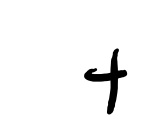

In [33]:
import random
from PIL import Image

# Set seed
random.seed(42) # <- try changing this and see what happens

# 1. Get all image paths (* means "any combination")
train_path = list(image_path.glob("*/*/*.jpg"))

# 2. Get random image path
random_image_path = random.choice(train_path)

# 3. Get image class from path name (the image class is the name of the directory where the image is stored)
image_class = random_image_path.parent.stem

# 4. Open image
img = Image.open(random_image_path)

# 5. Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
img

In [40]:
operation_classes = ['division','subtraction','addition', 'multiplication']

Adding basic operations to the MNIST dataset

In [57]:
class CustomOperatorDataset(Dataset):
    def __init__(self, root_dir, split='train', transform=None, base_class_offset=10):
        self.root_dir = os.path.join(root_dir, split)
        self.transform = transform
        self.base_class_offset = base_class_offset

        self.class_mapping = {
            'plus': 0,
            'minus': 1,
            'multiply': 2,
            'divide': 3
        }

        self.samples = []
        for class_name, class_idx in self.class_mapping.items():
            class_dir = os.path.join(self.root_dir, class_name)
            if not os.path.exists(class_dir):
                print(f"Warning: Directory {class_dir} not found")
                continue

            for img_name in os.listdir(class_dir):
                img_path = os.path.join(class_dir, img_name)
                if img_path.lower().endswith(('.png', '.jpg', '.jpeg')):
                    self.samples.append((img_path, class_idx + base_class_offset))

        print(f"Loaded {len(self.samples)} operator samples from {self.root_dir}")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = Image.open(img_path).convert('L')
        if self.transform:
            image = self.transform(image)
        return image, label


class CombinedDataset(Dataset):
    def __init__(self, mnist_dataset, custom_dataset):
        self.mnist = mnist_dataset
        self.custom = custom_dataset
        self.mnist_len = len(mnist_dataset)

    def __len__(self):
        return len(self.mnist) + len(self.custom)

    def __getitem__(self, idx):
        if idx < self.mnist_len:
            return self.mnist[idx]
        else:
            return self.custom[idx - self.mnist_len]


In [64]:
transform_pretrained = transforms.Compose([
    transforms.Resize(256, interpolation=InterpolationMode.BILINEAR),
    transforms.CenterCrop(224),
    transforms.Grayscale(num_output_channels=3),  # convert MNIST grayscale to RGB
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])


In [69]:
mnist_train = datasets.MNIST(
    root='.',
    train=True,
    download=True,
    transform=transform_pretrained
)

mnist_test = datasets.MNIST(
    root='/content/',
    train=False,
    download=True,
    transform=transform_pretrained
)

custom_train = CustomOperatorDataset(
    root_dir='/content/arithmetic-detection/handwritten_operations',
    split='train',
    transform=transform_pretrained,
    base_class_offset=10
)

custom_eval = CustomOperatorDataset(
    root_dir='/content/arithmetic-detection/handwritten_operations',
    split='eval',
    transform=transform_pretrained,
    base_class_offset=10
)

combined_train = CombinedDataset(mnist_train, custom_train)
combined_test = CombinedDataset(mnist_test, custom_eval)

train_loader = torch.utils.data.DataLoader(
    combined_train,
    batch_size=64,
    shuffle=True,
    num_workers=2,
)

test_loader = torch.utils.data.DataLoader(
    combined_test,
    batch_size=64,
    shuffle=False,
    num_workers=2
)


Loaded 2193 operator samples from /content/arithmetic-detection/handwritten_operations/train
Loaded 316 operator samples from /content/arithmetic-detection/handwritten_operations/eval


In [71]:
# Get the default weights
weights = models.ResNet18_Weights.DEFAULT
weights


ResNet18_Weights.IMAGENET1K_V1

In [72]:
model = models.resnet18(weights=weights).to(device)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 214MB/s]


In [77]:
summary(model=model,
        input_size=(32, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ResNet (ResNet)                          [32, 3, 224, 224]    [32, 1000]           --                   True
├─Conv2d (conv1)                         [32, 3, 224, 224]    [32, 64, 112, 112]   9,408                True
├─BatchNorm2d (bn1)                      [32, 64, 112, 112]   [32, 64, 112, 112]   128                  True
├─ReLU (relu)                            [32, 64, 112, 112]   [32, 64, 112, 112]   --                   --
├─MaxPool2d (maxpool)                    [32, 64, 112, 112]   [32, 64, 56, 56]     --                   --
├─Sequential (layer1)                    [32, 64, 56, 56]     [32, 64, 56, 56]     --                   True
│    └─BasicBlock (0)                    [32, 64, 56, 56]     [32, 64, 56, 56]     --                   True
│    │    └─Conv2d (conv1)               [32, 64, 56, 56]     [32, 64, 56, 56]     36,864               True
│    │    └─BatchN

In [79]:
for param in model.parameters():
    param.requires_grad = False

In [92]:
# Set the manual seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Get the length of class_names (one output unit for each class)
output_shape = len(class_names)

model.fc = torch.nn.Linear(
    in_features=512,  # ResNet18 has 512 features, not 1280
    out_features=14   # Your 14 classes
).to(device)

In [93]:
# # Do a summary *after* freezing the features and changing the output classifier layer (uncomment for actual output)
summary(model,
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape" (batch_size, color_channels, height, width)
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ResNet (ResNet)                          [32, 3, 224, 224]    [32, 14]             17,934               Partial
├─Conv2d (conv1)                         [32, 3, 224, 224]    [32, 64, 112, 112]   (9,408)              False
├─BatchNorm2d (bn1)                      [32, 64, 112, 112]   [32, 64, 112, 112]   (128)                False
├─ReLU (relu)                            [32, 64, 112, 112]   [32, 64, 112, 112]   --                   --
├─MaxPool2d (maxpool)                    [32, 64, 112, 112]   [32, 64, 56, 56]     --                   --
├─Sequential (layer1)                    [32, 64, 56, 56]     [32, 64, 56, 56]     --                   False
│    └─BasicBlock (0)                    [32, 64, 56, 56]     [32, 64, 56, 56]     --                   False
│    │    └─Conv2d (conv1)               [32, 64, 56, 56]     [32, 64, 56, 56]     (36,864)             False
│    │    

In [94]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=0.01
)

In [95]:
"""
Contains functions for training and testing a PyTorch model.
"""
import torch

from tqdm.auto import tqdm
from typing import Dict, List, Tuple

def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device) -> Tuple[float, float]:
    """Trains a PyTorch model for a single epoch.

    Turns a target PyTorch model to training mode and then
    runs through all of the required training steps (forward
    pass, loss calculation, optimizer step).

    Args:
    model: A PyTorch model to be trained.
    dataloader: A DataLoader instance for the model to be trained on.
    loss_fn: A PyTorch loss function to minimize.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
    A tuple of training loss and training accuracy metrics.
    In the form (train_loss, train_accuracy). For example:

    (0.1112, 0.8743)
    """
    # Put model in train mode
    model.train()

    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0

    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: torch.device) -> Tuple[float, float]:
    """Tests a PyTorch model for a single epoch.

    Turns a target PyTorch model to "eval" mode and then performs
    a forward pass on a testing dataset.

    Args:
    model: A PyTorch model to be tested.
    dataloader: A DataLoader instance for the model to be tested on.
    loss_fn: A PyTorch loss function to calculate loss on the test data.
    device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
    A tuple of testing loss and testing accuracy metrics.
    In the form (test_loss, test_accuracy). For example:

    (0.0223, 0.8985)
    """
    # Put model in eval mode
    model.eval()

    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0

    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

    # Adjust metrics to get average loss and accuracy per batch
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device) -> Dict[str, List]:
    """Trains and tests a PyTorch model.

    Passes a target PyTorch models through train_step() and test_step()
    functions for a number of epochs, training and testing the model
    in the same epoch loop.

    Calculates, prints and stores evaluation metrics throughout.

    Args:
    model: A PyTorch model to be trained and tested.
    train_dataloader: A DataLoader instance for the model to be trained on.
    test_dataloader: A DataLoader instance for the model to be tested on.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    loss_fn: A PyTorch loss function to calculate loss on both datasets.
    epochs: An integer indicating how many epochs to train for.
    device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
    A dictionary of training and testing loss as well as training and
    testing accuracy metrics. Each metric has a value in a list for
    each epoch.
    In the form: {train_loss: [...],
              train_acc: [...],
              test_loss: [...],
              test_acc: [...]}
    For example if training for epochs=2:
             {train_loss: [2.0616, 1.0537],
              train_acc: [0.3945, 0.3945],
              test_loss: [1.2641, 1.5706],
              test_acc: [0.3400, 0.2973]}
    """
    # Create empty results dictionary
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []
    }

    # Make sure model on target device
    model.to(device)

    # Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          device=device)
        test_loss, test_acc = test_step(model=model,
          dataloader=test_dataloader,
          loss_fn=loss_fn,
          device=device)

        # Print out what's happening
        print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
        )

        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    # Return the filled results at the end of the epochs
    return results

In [96]:
from timeit import default_timer as timer
start_time = timer()

# Setup training and save the results
results = train(model=model,
                       train_dataloader=train_loader,
                       test_dataloader=test_loader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=5,
                       device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.3331 | train_acc: 0.9022 | test_loss: 0.1759 | test_acc: 0.9475
Epoch: 2 | train_loss: 0.2183 | train_acc: 0.9372 | test_loss: 0.2499 | test_acc: 0.9305
Epoch: 3 | train_loss: 0.2291 | train_acc: 0.9388 | test_loss: 0.2149 | test_acc: 0.9466
Epoch: 4 | train_loss: 0.2380 | train_acc: 0.9415 | test_loss: 0.1774 | test_acc: 0.9588
Epoch: 5 | train_loss: 0.2218 | train_acc: 0.9463 | test_loss: 0.2708 | test_acc: 0.9409
[INFO] Total training time: 714.695 seconds


In [97]:
def plot_loss_curves(results: Dict[str, List[float]]):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """

    # Get the loss values of the results dictionary (training and test)
    loss = results['train_loss']
    test_loss = results['test_loss']

    # Get the accuracy values of the results dictionary (training and test)
    accuracy = results['train_acc']
    test_accuracy = results['test_acc']

    # Figure out how many epochs there were
    epochs = range(len(results['train_loss']))

    # Setup a plot
    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();

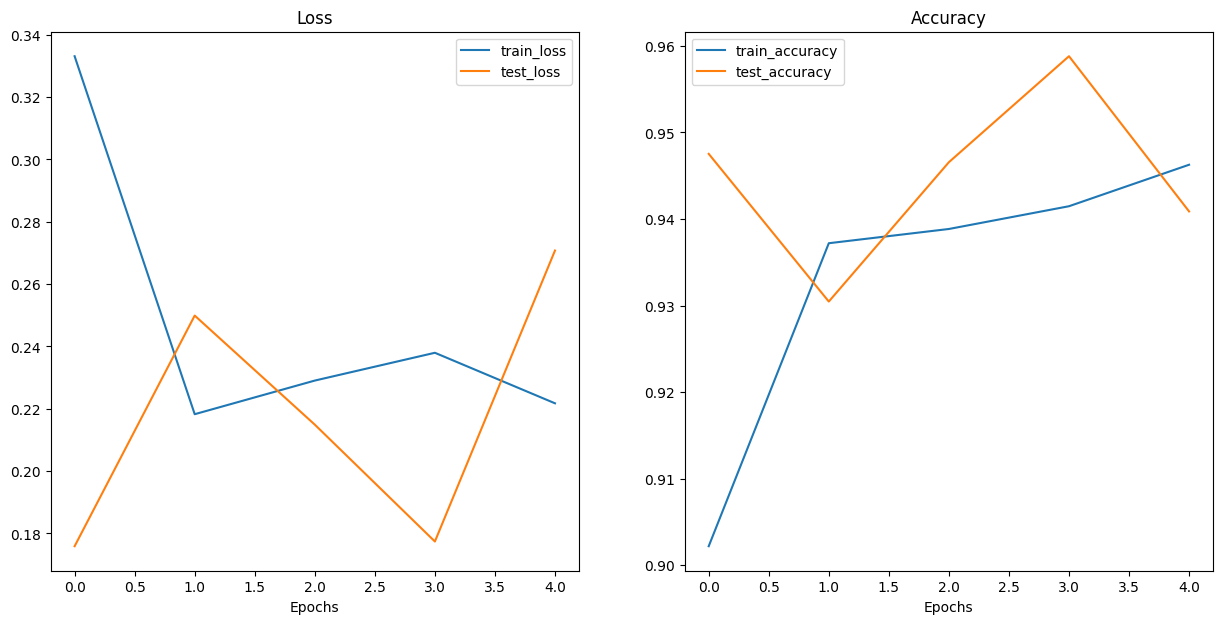

In [98]:
plot_loss_curves(results)

In [99]:
# Assuming you have your model and results
best_epoch = 4  # Based on your analysis

# Save the best model manually
torch.save({
    'epoch': best_epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'test_accuracy': 0.9588,  # From your results
    'test_loss': 0.1774,
}, f'best_model_epoch_{best_epoch}.pth')

print(f"✅ Best model (Epoch {best_epoch}) saved!")

✅ Best model (Epoch 4) saved!


In [111]:
data_path = Path('/content/test_file/')

In [112]:
custom_image_path = data_path / "handwittennumber.jpg"
custom_image_uint8 = torchvision.io.read_image(str(custom_image_path))

In [113]:


# Try to make a prediction on image in uint8 format (this will error)
model.eval()
with torch.inference_mode():
    model(custom_image_uint8.to(device))


RuntimeError: Input type (torch.cuda.ByteTensor) and weight type (torch.cuda.FloatTensor) should be the same

Testing a handwritten sample


In [108]:
import torchvision

In [114]:
# Load in custom image and convert the tensor values to float32
custom_image = torchvision.io.read_image(custom_image_path).type(torch.float32)

# Divide the image pixel values by 255 to get them between [0, 1]
custom_image = custom_image / 255.

# Print out image data
print(f"Custom image tensor:\n{custom_image}\n")
print(f"Custom image shape: {custom_image.shape}\n")
print(f"Custom image dtype: {custom_image.dtype}")

Custom image tensor:
tensor([[[0.6078, 0.6118, 0.6196,  ..., 0.6745, 0.6745, 0.6745],
         [0.6118, 0.6157, 0.6235,  ..., 0.6784, 0.6784, 0.6824],
         [0.6196, 0.6235, 0.6235,  ..., 0.6824, 0.6863, 0.6863],
         ...,
         [0.5137, 0.5137, 0.5137,  ..., 0.6706, 0.6706, 0.6745],
         [0.5137, 0.5137, 0.5098,  ..., 0.6667, 0.6667, 0.6667],
         [0.5098, 0.5098, 0.5098,  ..., 0.6627, 0.6667, 0.6667]],

        [[0.5137, 0.5176, 0.5255,  ..., 0.5765, 0.5765, 0.5765],
         [0.5176, 0.5216, 0.5294,  ..., 0.5804, 0.5804, 0.5843],
         [0.5255, 0.5294, 0.5294,  ..., 0.5843, 0.5882, 0.5882],
         ...,
         [0.3961, 0.3961, 0.3961,  ..., 0.5725, 0.5725, 0.5765],
         [0.3961, 0.3961, 0.3922,  ..., 0.5686, 0.5686, 0.5686],
         [0.3922, 0.3922, 0.3922,  ..., 0.5647, 0.5686, 0.5686]],

        [[0.4196, 0.4235, 0.4314,  ..., 0.4902, 0.4902, 0.4902],
         [0.4235, 0.4275, 0.4353,  ..., 0.4941, 0.4941, 0.4980],
         [0.4314, 0.4353, 0.4353,  ..

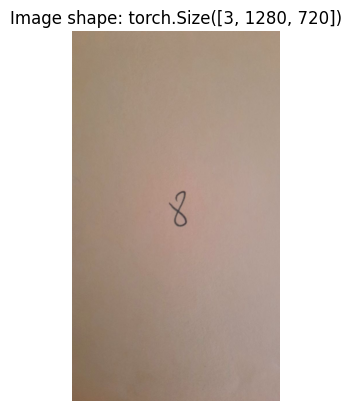

In [115]:
# Plot custom image
plt.imshow(custom_image.permute(1, 2, 0)) # need to permute image dimensions from CHW -> HWC otherwise matplotlib will error
plt.title(f"Image shape: {custom_image.shape}")
plt.axis(False);

In [119]:
custom_image_pil = transforms.ToPILImage()(custom_image)

custom_image_transformed = transform_pretrained(custom_image_pil)

print(f"Original shape: {custom_image.shape}")
print(f"Transformed shape: {custom_image_transformed.shape}")

Original shape: torch.Size([3, 1280, 720])
Transformed shape: torch.Size([3, 224, 224])


In [120]:
model.eval()
with torch.inference_mode():
    # Add an extra dimension to image
    custom_image_transformed_with_batch_size = custom_image_transformed.unsqueeze(dim=0)

    # Print out different shapes
    print(f"Custom image transformed shape: {custom_image_transformed.shape}")
    print(f"Unsqueezed custom image shape: {custom_image_transformed_with_batch_size.shape}")

    # Make a prediction on image with an extra dimension
    custom_image_pred = model(custom_image_transformed.unsqueeze(dim=0).to(device))

Custom image transformed shape: torch.Size([3, 224, 224])
Unsqueezed custom image shape: torch.Size([1, 3, 224, 224])


In [122]:
def predict_image(model, image_tensor, class_names, device):
    """
    Make prediction on a single image tensor
    """
    # Add batch dimension and move to device
    image_batch = image_tensor.unsqueeze(0).to(device)

    # Set model to evaluation mode
    model.eval()

    # Make prediction
    with torch.no_grad():
        output = model(image_batch)
        probabilities = torch.softmax(output, dim=1)
        confidence, predicted_idx = torch.max(probabilities, 1)

    # Convert to Python values
    confidence_score = confidence.item()
    predicted_idx = predicted_idx.item()
    predicted_class = class_names[predicted_idx]

    return predicted_class, confidence_score, probabilities

# Usage
predicted_class, confidence, all_probabilities = predict_image(
    model=model,
    image_tensor=custom_image_transformed,
    class_names=class_names,
    device=device
)

print(f"Predicted: {predicted_class} with {confidence:.2%} confidence")

Predicted: - with 99.94% confidence


In [123]:
predict_image(model,custom_image_pred,class_names, device )

RuntimeError: Given groups=1, weight of size [64, 3, 7, 7], expected input[1, 1, 1, 14] to have 3 channels, but got 1 channels instead

In [126]:
from PIL import Image
import torchvision.transforms as transforms

# Your existing transform
transform_pretrained = transforms.Compose([
    transforms.Resize(256, interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.CenterCrop(224),
    transforms.Grayscale(num_output_channels=3),  # convert to RGB
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

# DEFINE YOUR CLASS NAMES (replace with your actual classes)
class_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '+', '-', '*', '/']  # ⬅️ ADD THIS LINE
# Example: class_names = ['cat', 'dog', 'bird', 'car', 'plane']

# Load image directly from path and transform
image_path = '/content/test_file/handwittennumber.jpg'  # Replace with your actual path

# Load image using PIL
image_pil = Image.open(image_path)

# Apply your transform
transformed_image = transform_pretrained(image_pil)

print(f"Original image size: {image_pil.size}")  # (width, height)
print(f"Transformed shape: {transformed_image.shape}")  # [3, 224, 224]

# Now make prediction
image_batch = transformed_image.unsqueeze(0).to(device)  # Add batch dimension

model.eval()
with torch.no_grad():
    output = model(image_batch)
    probabilities = torch.softmax(output, dim=1)
    confidence, predicted_idx = torch.max(probabilities, 1)

# Get prediction
predicted_class = class_names[predicted_idx.item()]  # This will now work!
confidence_score = confidence.item()

print(f"🎯 Prediction: {predicted_class}")
print(f"📊 Confidence: {confidence_score:.4f}")
print(f"🔢 Predicted index: {predicted_idx.item()}")

Original image size: (720, 1280)
Transformed shape: torch.Size([3, 224, 224])
🎯 Prediction: -
📊 Confidence: 0.9994
🔢 Predicted index: 11


In [125]:
class_names

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '+', '-', '*', '/']

In [127]:
# Test multiple images
test_images = [
    '/content/test_file/96-965294_2-hand-written-number-2.png',
    # Add more image paths here
]

for img_path in test_images:
    try:
        image = Image.open(img_path)
        transformed = transform_pretrained(image)
        image_batch = transformed.unsqueeze(0).to(device)

        model.eval()
        with torch.no_grad():
            output = model(image_batch)
            probabilities = torch.softmax(output, dim=1)
            confidence, predicted_idx = torch.max(probabilities, 1)

        predicted_class = class_names[predicted_idx.item()]
        confidence_score = confidence.item()

        print(f"📸 {img_path}")
        print(f"🎯 Prediction: '{predicted_class}' (index {predicted_idx.item()})")
        print(f"📊 Confidence: {confidence_score:.4f}\n")

    except Exception as e:
        print(f"❌ Error with {img_path}: {e}\n")

📸 /content/test_file/96-965294_2-hand-written-number-2.png
🎯 Prediction: '1' (index 1)
📊 Confidence: 1.0000

